# Downloading Sentinel-1 Synthetic Aperture Radar (SAR)

References:
- https://planetarycomputer.microsoft.com/dataset/group/sentinel-1
- https://github.com/microsoft/PlanetaryComputerExamples/blob/main/datasets/sentinel-1-grd/sentinel-1-grd-example.ipynb
- https://planetarycomputer.microsoft.com/docs/tutorials/customizable-rtc-sentinel1/

In [1]:
# can replace these imports using requirements. txt and the following command
# %pip install -r requirements.txt

import pystac_client
import planetary_computer
import rioxarray
import xarray as xr
import numpy as np
import rich.table
from IPython.display import Image
import pandas as pd
import seaborn as sns

import os
import rioxarray

import sarsen

import adlfs
import planetary_computer
import pystac_client
import stackstac

from scipy.ndimage import uniform_filter
from scipy.ndimage import variance
from skimage.filters import threshold_minimum

import matplotlib.pyplot as plt

In [2]:
# region of interest in South Florida
lon, lat = [-81.68182, 26.84941]
buffer = 0.2
bbox = [lon - buffer, lat - buffer, lon + buffer, lat + buffer]
time_of_interest = "2025-02-01/2025-02-28"

In [3]:
# out
dem_path = 'data/southfl_3dep_seamless_dem.tif'

In [4]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

## DEM

In [5]:
search = catalog.search(
    collections="3dep-seamless", bbox=bbox, query={"gsd": {"eq": 10}}
)
items = search.item_collection()

In [6]:
dem_raster_all = stackstac.stack(items, bounds=bbox, epsg=5498).squeeze()
dem_raster_all

<xarray.DataArray 'stackstac-9d75c3c07a18678655f04b8dfbec52ef' (time: 2,
                                                                y: 4321, x: 4321)> Size: 299MB
dask.array<getitem, shape=(2, 4321, 4321), dtype=float64, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/13)
  * time             (time) datetime64[ns] 16B 2018-04-26 2019-10-16
    id               (time) <U10 80B 'n28w082-13' 'n27w082-13'
    band             <U4 16B 'data'
  * x                (x) float64 35kB -81.88 -81.88 -81.88 ... -81.48 -81.48
  * y                (y) float64 35kB 27.05 27.05 27.05 ... 26.65 26.65 26.65
    threedep:region  <U6 24B 'n20w90'
    ...               ...
    gsd              int64 8B 10
    proj:shape       object 8B {10812}
    end_datetime     (time) <U20 160B '2016-12-31T00:00:00Z' '2018-12-17T00:0...
    start_datetime   (time) <U20 160B '1950-01-01T00:00:00Z' '2018-06-02T00:0...
    description      <U1849 7kB 'This tile of the 3D Elevation Program (3DEP)...
    epsg             int64 8B 5498
Attributes:
    spec:           RasterSpec(epsg=5498, bounds=(-81.88185179282144, 26.6493...
    crs:            epsg:5498
    transform:      | 0.00, 0.00,-81.88|\n| 0.00,-0.00, 27.05|\n| 0.00, 0.00,...
    resolution_xy:  (9.259259252584056e-05, 9.259259252584155e-05)

In [7]:
# avg
dem_raster_geo = dem_raster_all.compute()
if "time" in dem_raster_geo.dims:
    dem_raster_geo = dem_raster_geo.mean("time")
_ = dem_raster_geo.rio.set_crs(dem_raster_all.rio.crs)

C:\Users\twuli\AppData\Local\Temp\ipykernel_2232\2972389079.py:5: FutureWarning: It is recommended to use 'rio.write_crs()' instead. 'rio.set_crs()' will likelybe removed in a future release.
  _ = dem_raster_geo.rio.set_crs(dem_raster_all.rio.crs)


In [8]:
# find the UTM zone and project in UTM
t_srs = dem_raster_geo.rio.estimate_utm_crs()
dem_raster = dem_raster_geo.rio.reproject(t_srs, resolution=(10, 10))

# crop DEM to our area of interest and save it
# dem_corners = dict(x=slice(565000, 594000), y=slice(5220000, 5190000))

# dem_raster = dem_raster.sel(**dem_corners)
dem_raster.rio.to_raster(dem_path)
dem_raster

RasterioIOError: Attempt to create new tiff file 'data/southfl_3dep_seamless_dem.tif' failed: No such file or directory

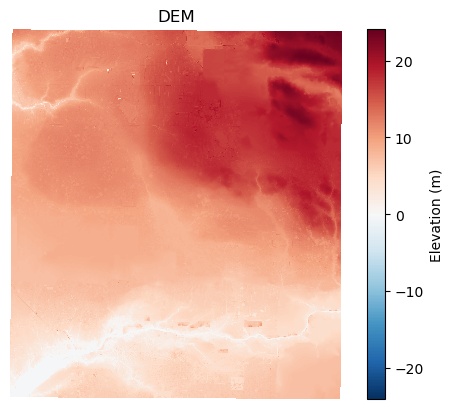

In [ ]:
dem_raster = rioxarray.open_rasterio("data/southfl_3dep_seamless_dem.tif")
plot = dem_raster.plot(add_colorbar=False)
plt.title("DEM")
plt.grid(False)
plt.gca().set_aspect('equal')
plt.gca().set_axis_off()
cbar = plt.colorbar(plot)
cbar.set_label("Elevation (m)")

## Get Sentinel-1 (Not Used Anymore)

In [ ]:
# retrieve data from planetary computer
search = catalog.search(
    collections=["sentinel-1-grd"],
    bbox=bbox,
    datetime=time_of_interest,
)

items = search.item_collection()
print(f"Returned {len(items)} Items")

Returned 5 Items


In [ ]:
# show most recent image
item = items[0]
Image(url=item.assets["rendered_preview"].href)

In [ ]:
# get metadata
table = rich.table.Table("key", "value")
for k, v in sorted(item.properties.items()):
    table.add_row(k, str(v))

table

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ key                                   ┃ value                            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ constellation                         │ Sentinel-1                       │
│ datetime                              │ 2025-02-24T23:28:52.887652Z      │
│ end_datetime                          │ 2025-02-24 23:29:05.387163+00:00 │
│ platform                              │ SENTINEL-1A                      │
│ s1:datatake_id                        │ 469653                           │
│ s1:instrument_configuration_ID        │ 7                                │
│ s1:orbit_source                       │ RESORB                           │
│ s1:processing_level                   │ 1                                │
│ s1:product_timeliness                 │ Fast-24h                         │
│ s1:resolution                         │ high                             │
│ s1:shape                              │ [25660, 16748]                   │
│ s1:slice_number                       │ 14                               │
│ s1:total_slices                       │ 23                               │
│ sar:center_frequency                  │ 5.405                            │
│ sar:frequency_band                    │ C                                │
│ sar:instrument_mode                   │ IW                               │
│ sar:looks_azimuth                     │ 1                                │
│ sar:looks_equivalent_number           │ 4.4                              │
│ sar:looks_range                       │ 5                                │
│ sar:observation_direction             │ right                            │
│ sar:pixel_spacing_azimuth             │ 10                               │
│ sar:pixel_spacing_range               │ 10                               │
│ sar:polarizations                     │ ['VV', 'VH']                     │
│ sar:product_type                      │ GRD                              │
│ sar:resolution_azimuth                │ 22                               │
│ sar:resolution_range                  │ 20                               │
│ sat:absolute_orbit                    │ 58045                            │
│ sat:orbit_state                       │ ascending                        │
│ sat:platform_international_designator │ 2014-016A                        │
│ sat:relative_orbit                    │ 48                               │
│ start_datetime                        │ 2025-02-24 23:28:40.388141+00:00 │
└───────────────────────────────────────┴──────────────────────────────────┘

In [ ]:
s1_path = item.assets['safe-manifest'].href
print(s1_path)

https://sentinel1euwest.blob.core.windows.net/s1-grd/GRD/2025/2/24/IW/DV/S1A_IW_GRDH_1SDV_20250224T232840_20250224T232905_058045_072A95_4FD8/manifest.safe?st=2025-04-19T16%3A12%3A45Z&se=2025-04-20T16%3A57%3A45Z&sp=rl&sv=2024-05-04&sr=c&skoid=9c8ff44a-6a2c-4dfb-b298-1c9212f64d9a&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2025-04-20T13%3A39%3A42Z&ske=2025-04-27T13%3A39%3A42Z&sks=b&skv=2024-05-04&sig=V%2B0efu6BGJ6ePF4Xhs/XwDkzJ959vCRMZBm2zPG/ksk%3D


In [ ]:
# get pixel data
vv = (
    rioxarray.open_rasterio(item.assets["vv"].href, overview_level=2)
    .astype(float)
    .squeeze()
)
vh = (
    rioxarray.open_rasterio(item.assets["vh"].href, overview_level=2)
    .astype(float)
    .squeeze()
)

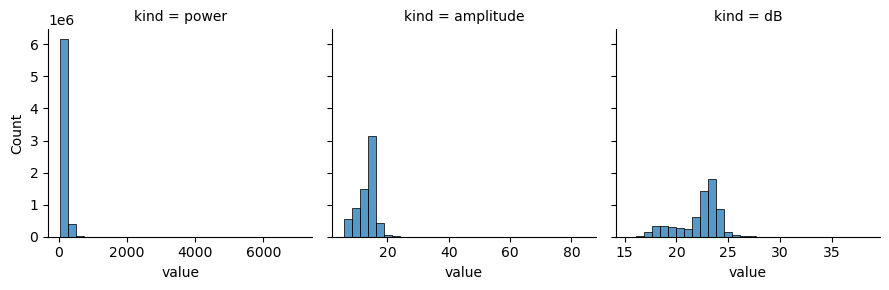

In [ ]:
# plot distribution of pixel values
raw = vv.where(lambda x: x > 0).data.ravel()
df = (
    pd.DataFrame({"power": raw, "amplitude": np.sqrt(raw), "dB": 10 * np.log10(raw)})
    .dropna()
    .melt(value_vars=["power", "amplitude", "dB"], var_name="kind")
)

g = sns.FacetGrid(df, sharex=False, col="kind")
g.map(sns.histplot, "value", bins=30)

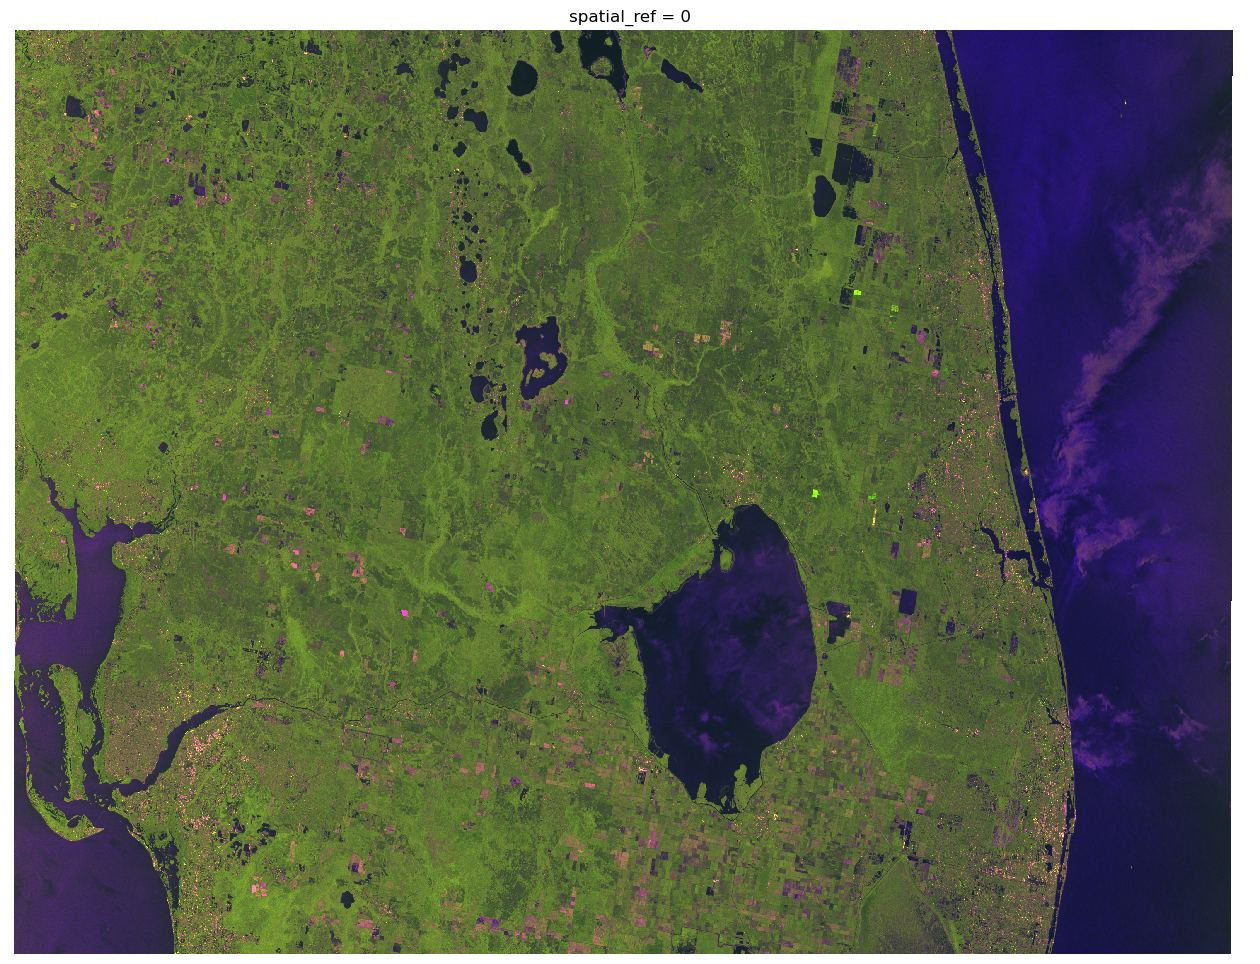

In [ ]:
# show false color image (rescaled data)
r = vv / 600
g = vh / 270
b = (vv / vh) / 9
data = xr.concat([r, g, b], dim="band").clip(0, 1).where(lambda x: x > 0)
img = data.plot.imshow(rgb="band", size=12)
img.axes.set_axis_off()

## Terrain Correction

In [ ]:
# path to Sentinel-1 input product in the Planetary Computer
product_folder = 'GRD/2025/2/24/IW/DV/S1A_IW_GRDH_1SDV_20250224T232840_20250224T232905_058045_072A95_4FD8'

In [ ]:
grd_account_name = "sentinel1euwest"
grd_storage_container = "s1-grd"
grd_product_folder = f"{grd_storage_container}/{product_folder}"
grd_local_path = os.path.join('data', product_folder)

In [ ]:
grd_token = planetary_computer.sas.get_token(
    grd_account_name, grd_storage_container
).token
grd_fs = adlfs.AzureBlobFileSystem(grd_account_name, credential=grd_token)
grd_fs.ls(f"{grd_product_folder}/manifest.safe")

['s1-grd/GRD/2025/2/24/IW/DV/S1A_IW_GRDH_1SDV_20250224T232840_20250224T232905_058045_072A95_4FD8/manifest.safe']

In [ ]:
grd_fs.get(grd_product_folder, grd_local_path, recursive=True)
!ls -d {grd_local_path}

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
product = sarsen.Sentinel1SarProduct(
   grd_local_path,
   measurement_group="IW/VV",
)

gtc = sarsen.terrain_correction(
    product=product,
    dem_urlpath=dem_path,
    output_urlpath="data/southfl_sentinel1_10m_GTC_terrain_corrected.tif"
)

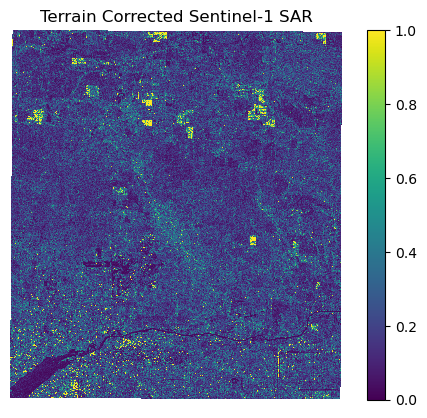

In [ ]:
tc = rioxarray.open_rasterio("data/southfl_sentinel1_10m_GTC_terrain_corrected.tif")
plot = tc.plot(vmin=0, vmax=1, cmap="viridis", add_colorbar=False)
plt.title("Terrain Corrected Sentinel-1 SAR")
plt.grid(False)
plt.gca().set_aspect('equal')
plt.gca().set_axis_off()
cbar = plt.colorbar(plot)
cbar.set_label("")

## Filter (In Progress)
https://docs.digitalearthafrica.org/en/latest/sandbox/notebooks/Real_world_examples/Radar_water_detection.html

In [ ]:
# defining a function to apply lee filtering on S1 image
def lee_filter(da, size):
    """
    Apply lee filter of specified window size.
    Adapted from https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python

    """
    img = da.values
    img_mean = uniform_filter(img, size)
    img_sqr_mean = uniform_filter(img**2, size)
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)

    return img_output